**Goal:** Use numpy to calculate the correlation matrix for several filtered versions of the example data set, then use BioPython to cluster the final filtered matrix.

## Tools

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import gzip
from csv import reader, excel_tab
import numpy as np

## Data

In [3]:
fp = reader(gzip.open("GSE86922_Brodsky_GEO_processed.txt.gz"), dialect = excel_tab)
header = fp.next()
data = []
annotations = []
for row in fp:
    annotations.append(row[:4])
    data.append([float(i) for i in row[4:]])
# This is new -- we deallocate the reader object to close the file when we're done reading it
del fp

## First pass: full data matrix

Convert our list of lists to a numpy array.  This gives us access to fast numpy matrix functions.

In [4]:
d = np.array(data)
d.shape

(44340, 12)

We'll plot our matrix as we transform and filter it.

Here is the original matrix:

<IPython.core.display.Javascript object>


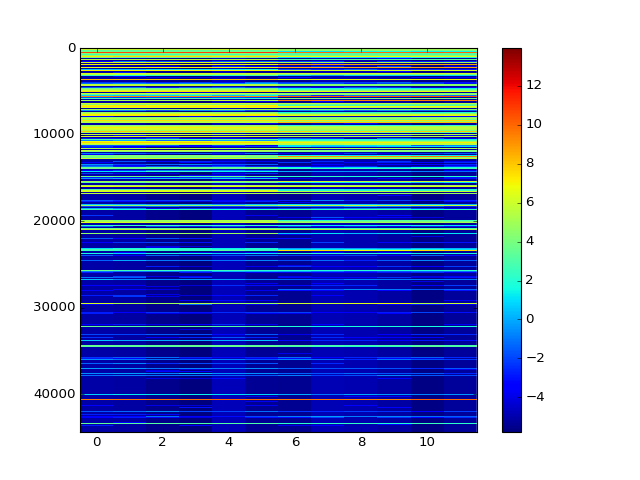

In [5]:
fig = plt.figure()
plt.imshow(d, interpolation = "none", aspect = "auto")
plt.colorbar()

In the heatmap above, note that most of the transcripts are blue, due to not being expressed.  Also note that the columns look mostly the same.  Most genes have low differential expression relative to their basal expression level, so mean abundance is much easier to see than the differences between samples.

Mean center the rows.  Since each row is a gene, this puts the samples with "typical" expression at 0, samples where the gene is upregulated at positive values, and samples where the gene is down regulated at negative values.

We use **axis=1** in np.mean to indicate that it should iterate over columns (dimension 1), giving row means.  **axis=0** would iterate over rows (dimension 0), giving column means.

In [6]:
mean = np.mean(d, axis = 1)
mean.shape

(44340,)

The result of mean is a 1 dimensional array, which is not compatable with our 2 dimensional matrix.  Therefore, we **reshape** it to "2 dimensions".

In [7]:
mean = mean.reshape(mean.shape[0],1)
mean.shape

(44340, 1)

Now we have compatable arrays for subtracting the row means:

In [8]:
centered = d - mean

<IPython.core.display.Javascript object>


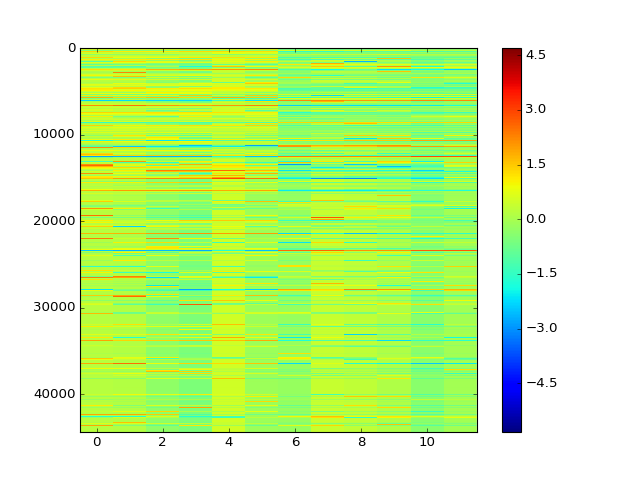

In [9]:
fig = plt.figure()
plt.imshow(centered, interpolation = "none", aspect = "auto")
plt.colorbar()

In the previous heatmap, mean abundance was the dominant signal.  This is specifically what we removed by subtraction, so our new heatmap emphasizes differential expression among samples.  Most genes are *not* differentially expressed, so this looks flat.

Now we scale each gene row to a unit vector by dividing by its length.

In [10]:
norm = np.linalg.norm(centered, axis = 1)
norm = norm.reshape(norm.shape[0], 1)
scaled = centered/norm

<IPython.core.display.Javascript object>


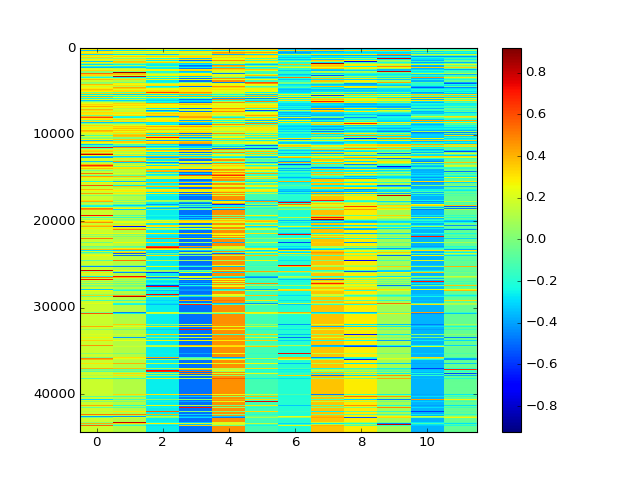

In [11]:
fig = plt.figure()
plt.imshow(scaled, interpolation = "none", aspect = "auto")
plt.colorbar()

This increases the contrast, as all rows are now on the same scale (-1 to 1).  Because most rows are noise for transcripts that aren't actually expressed, this is not very informative.

Since the rows of our matrix are now centered unit vectors, multiplying the matrix by its transpose (equivalent to taking the dot product of all pairs of vectors) yields to correlation matrix:

In [12]:
corr = np.dot(scaled, scaled.T)

MemoryError: 

Because numpy tries to allocate enough memory for the full result before starting, we find out right away that this calculation is too large to do in core memory.

Let's filter for actually detected transcripts:

## Second pass: just "detected" transcripts

We will create a text matrix of annotations parallel to the data matrix.  By carrying both matrices through our filtering steps, we can track which transcripts correspond to which rows in our final filtered data matrix.

In [13]:
anno = np.array([[i[0],i[3]] for i in annotations])
anno[0]

array(['ENSMUSG00000000001', 'Gnai3'], 
      dtype='|S19')

Threshold at 10 counts per million (CPM), as in the paper

In [14]:
thresh = np.log(10)/np.log(2)

numpy allows a very R-like compact syntax for filtering.

The logic here is:

1. **d >= thresh**: compare every value to the threshold, yielding a matrix with the same dimension as **d** with True or False values for the result of the comparison
2. **np.sum(..., axis = 1)**: take the row wise sum of the True/False matrix (with True=1 and False=0).  This is equivalent to counting the number of samples over threshold for each transcript.  The result is an integer vector as long as the number of rows of **d**
3. **( ... >= 2)**: as in step 1, compare every value in the integer vector from the previous step to 2.  So, we get a vector of the same length with True for transcripts observed at least twice and False otherwise.  We save this vector as **x**
4. **d[x,:]**: Form a new matrix taking rows where **x** is True and all columns.

In [15]:
x = (np.sum(d >= thresh, axis = 1) >= 2)
f = d[x,:]
fa = anno[x,:]
f.shape, fa.shape

((9740, 12), (9740, 2))

<IPython.core.display.Javascript object>


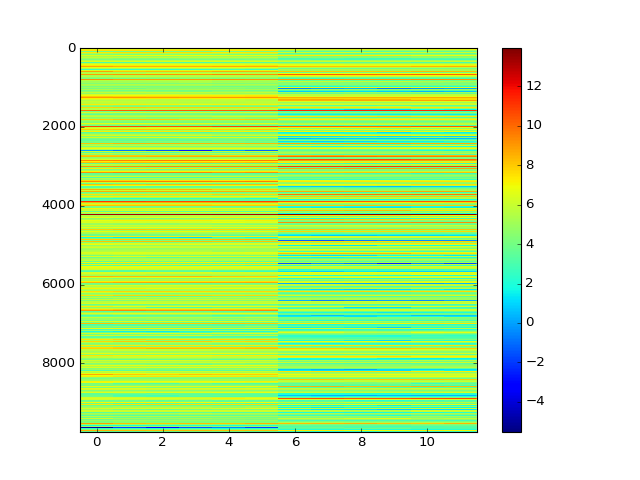

In [16]:
fig = plt.figure()
plt.imshow(f, interpolation = "none", aspect = "auto")
plt.colorbar()

Having cut to only observed transcripts *(i.e., the "real" signal)*, we see that the levels of most transcripts are independent of geneotype; they have a consistent level for the unstimulated (first 6) and LPS treated (second 6) conditions.

We will mean center and scale the rows as before:

In [17]:
mean = np.mean(f, axis = 1)
mean = mean.reshape(mean.shape[0],1)
centered = f - mean

<IPython.core.display.Javascript object>


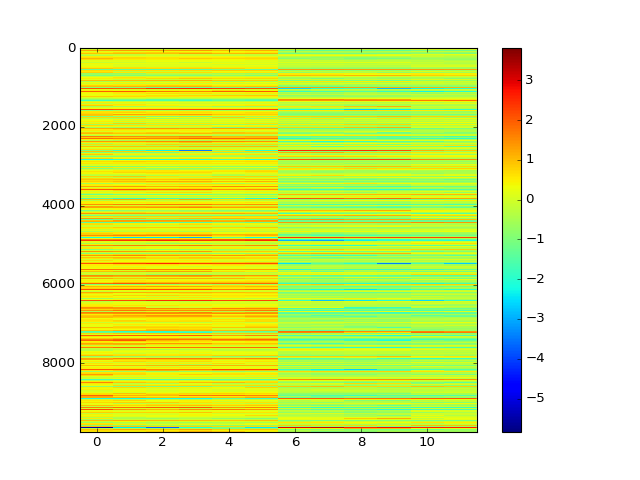

In [18]:
fig = plt.figure()
plt.imshow(centered, interpolation = "none", aspect = "auto")
plt.colorbar()

Having removed the mean abundance signal, we see a bias for "up in unstimulated relative to LPS"

In [19]:
norm = np.linalg.norm(centered, axis = 1)
norm = norm.reshape(norm.shape[0], 1)
scaled = centered/norm

<IPython.core.display.Javascript object>


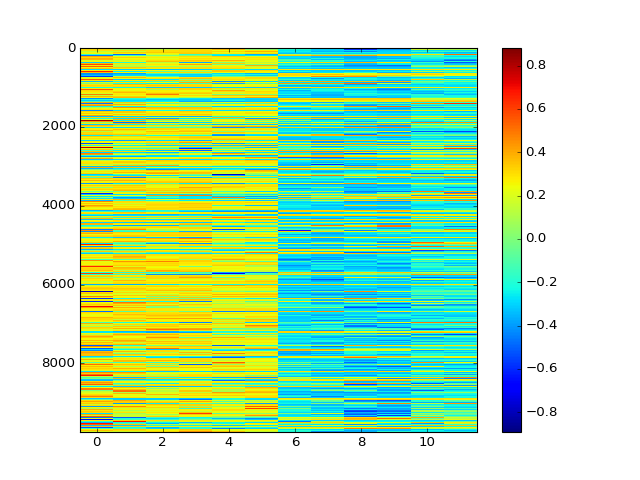

In [20]:
fig = plt.figure()
plt.imshow(scaled, interpolation = "none", aspect = "auto")
plt.colorbar()

Now we have a small enough data matrix to fit the correlation matrix in memory:

In [21]:
%%time
corr = np.dot(scaled, scaled.T)

CPU times: user 492 ms, sys: 92 ms, total: 584 ms
Wall time: 452 ms


Comparing to the previous run time of 10 minutes 39 seconds for the naive python implementation

In [22]:
(10.*60+39.)/.359

1779.9442896935934

Yay -- with numpy, we get a ~1500x speed up compared to the naive Python implementation.

This is still too big to conveniently plot, so let's aggressively filter for the most differential genes

## Third pass, very differentially expressed transcripts

Syntax is similar to the previous filter.  Here, we are comparing the largest and smallest value in each row to get the maximum fold change among the samples and filtering for transcripts with at least a 4x difference (1.5x-2x is more typical):

In [23]:
x = (np.max(f, axis = 1) - np.min(f, axis = 1) >= 2)
f2 = f[x,:]
fa2 = fa[x,:]
f2.shape, fa2.shape

((2779, 12), (2779, 2))

<IPython.core.display.Javascript object>


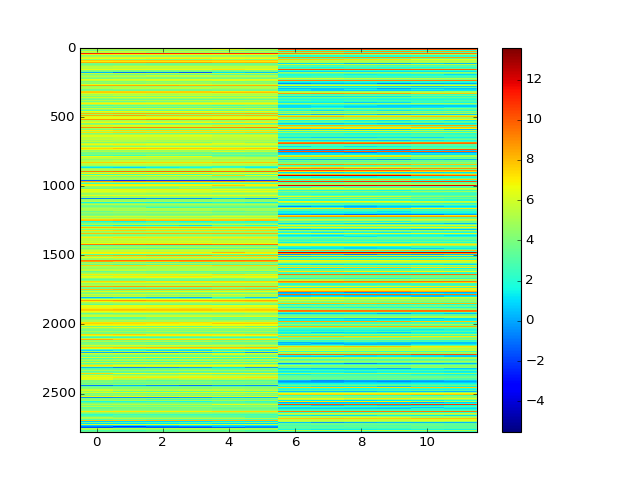

In [24]:
fig = plt.figure()
plt.imshow(f2, interpolation = "none", aspect = "auto")
plt.colorbar()

We requested genes with a large fold change, so now column differences are apparent even in the untransformed heatmap.  Note that we selected primarily for differences between unstimulated and LPS treated, as expected from our previous plots.

In [25]:
mean = np.mean(f2, axis = 1)
mean = mean.reshape(mean.shape[0],1)
centered = f2 - mean

<IPython.core.display.Javascript object>


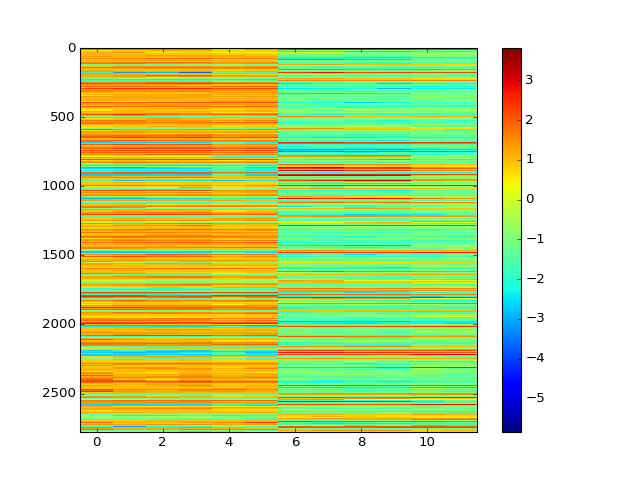

In [26]:
fig = plt.figure()
plt.imshow(centered, interpolation = "none", aspect = "auto")
plt.colorbar()

Again, mean centering makes it easier to see the differential expression.  Note that we can now pick out a few rows with the reverse trend -- "up in LPS relative to untreated"

In [27]:
norm = np.linalg.norm(centered, axis = 1)
norm = norm.reshape(norm.shape[0], 1)
scaled = centered/norm

<IPython.core.display.Javascript object>


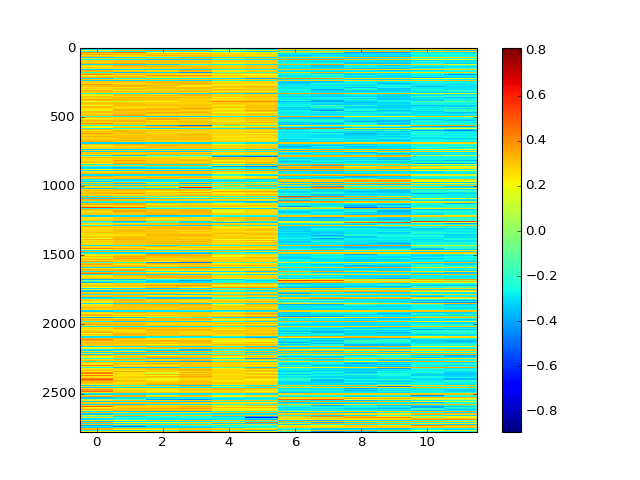

In [28]:
fig = plt.figure()
plt.imshow(scaled, interpolation = "none", aspect = "auto")
plt.colorbar()

Again, doing all pairwise dot products of the centered and scaled rows to get the correlation matrix:

In [29]:
%%time
corr = np.dot(scaled, scaled.T)

CPU times: user 48 ms, sys: 8 ms, total: 56 ms
Wall time: 32.2 ms


In [30]:
corr.shape

(2779, 2779)

And this matrix is small enough to conveniently plot

<IPython.core.display.Javascript object>


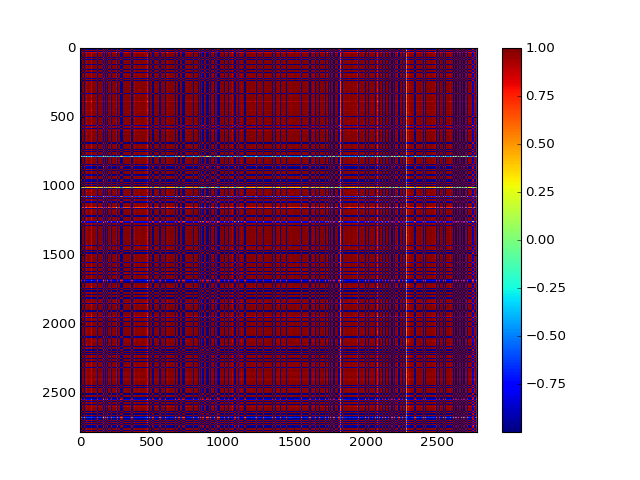

In [31]:
fig = plt.figure()
plt.imshow(corr, interpolation = "none", aspect = "auto")
plt.colorbar()

As expected, all correlation values are between -1 and 1.

The challenge is now to permute the rows and columns to put all of the strong correlation values on the diagonal -- this is the goal of clustering.

## Clustering

We will use Michael de Hoon's python bindings for his Cluster3 program.  Conveniently, these are included in Biopython:

In [32]:
import Bio.Cluster as Pycluster

Calculate the centered Pearson distance matrix using the Cluster3 code.  This is equal to 1 minus the correlation matrix (so, perfectly correlated transcripts are at distance 0 from each other, uncorrelated genes are at distance 1 and perfectly anticorrelated genes are at distance 2).

Setting **dist** to a value other than "c" would choose a different distance method; *e.g.*, "u" for uncentered Pearson distances (appropriate if the data is already transformed to a meaningful 0) or "e" for Euclidean distances.

In [33]:
dist = Pycluster.distancematrix(f2, dist = "c")

Perform hierarchical clustering with maximum ("m") linkage clustering.  This sets the distances for internal nodes to the maximum of the distances to their two children.  The result is a "chunky" dendrogram with many short branches and a few long ones, giving relatively few easily distinguishable clusters.  In contrast, average ("a") and centroid ("c") linkage clustering set distances to averages of the child distances which leads to more uniform branch lengths.

In [34]:
tree = Pycluster.treecluster(distancematrix = dist, method = "m")

Save the clustering result as a pair of tab delimited files: CDT for the row-permuted data matrix and GTR for the dendrogram (tree).

In [35]:
record = Pycluster.Record()
# Restore "None" values
record.data = f2
record.geneid = fa2[:,0]
record.genename = fa2[:,1]
record.gweight = None
record.gorder = None
record.expid = header[4:]
record.eweight = [1. for i in range(len(header) - 4)]
record.eorder = None
record.uniqid = "UNIQID"
record.save("clustered1_cm", geneclusters = tree)

Same thing, but use the centered and scaled data for the heatmap

*This is not so good, because the values are all very small relative to javatreeview's contrast range.  We could fix this by multiplying by a constant factor, but this would still have the disadvantage of obscuring the magnitude of differential expression.*

In [36]:
record = Pycluster.Record()
# Restore "None" values
record.data = scaled
record.geneid = fa2[:,0]
record.genename = fa2[:,1]
record.gweight = None
record.gorder = None
record.expid = header[4:]
record.eweight = [1. for i in range(len(header) - 4)]
record.eorder = None
record.uniqid = "UNIQID"
record.save("clustered1_cm_scaled", geneclusters = tree)

Same thing, but use the centered data for the heatmap -- this gives the best view in JavaTreeView *(even better would be picking an appropriate transform specific to this experiment)*

In [37]:
record = Pycluster.Record()
# Restore "None" values
record.data = centered
record.geneid = fa2[:,0]
record.genename = fa2[:,1]
record.gweight = None
record.gorder = None
record.expid = header[4:]
record.eweight = [1. for i in range(len(header) - 4)]
record.eorder = None
record.uniqid = "UNIQID"
record.save("clustered1_cm_centered", geneclusters = tree)

List the files that we just created

In [38]:
%ls clustered1_cm*.*

clustered1_cm.cdt           clustered1_cm.gtr
clustered1_cm_centered.cdt  clustered1_cm_scaled.cdt
clustered1_cm_centered.gtr  clustered1_cm_scaled.gtr
